# Web-Enhanced Self-Reflecting Agent

*Notebook by [Bilge Yucel](https://www.linkedin.com/in/bilge-yucel/)*

In this notebook, we will use [Ollama](https://haystack.deepset.ai/integrations/ollama), [Gemma2](https://ollama.com/library/gemma2) and Haystack to build a self-reflecting agent that can leverage web resources to augment its self-reflection and decision-making capabilities.

**📚 Useful Sources**

* [Docs](https://docs.haystack.deepset.ai/docs/intro)
* [Tutorials](https://haystack.deepset.ai/tutorials)

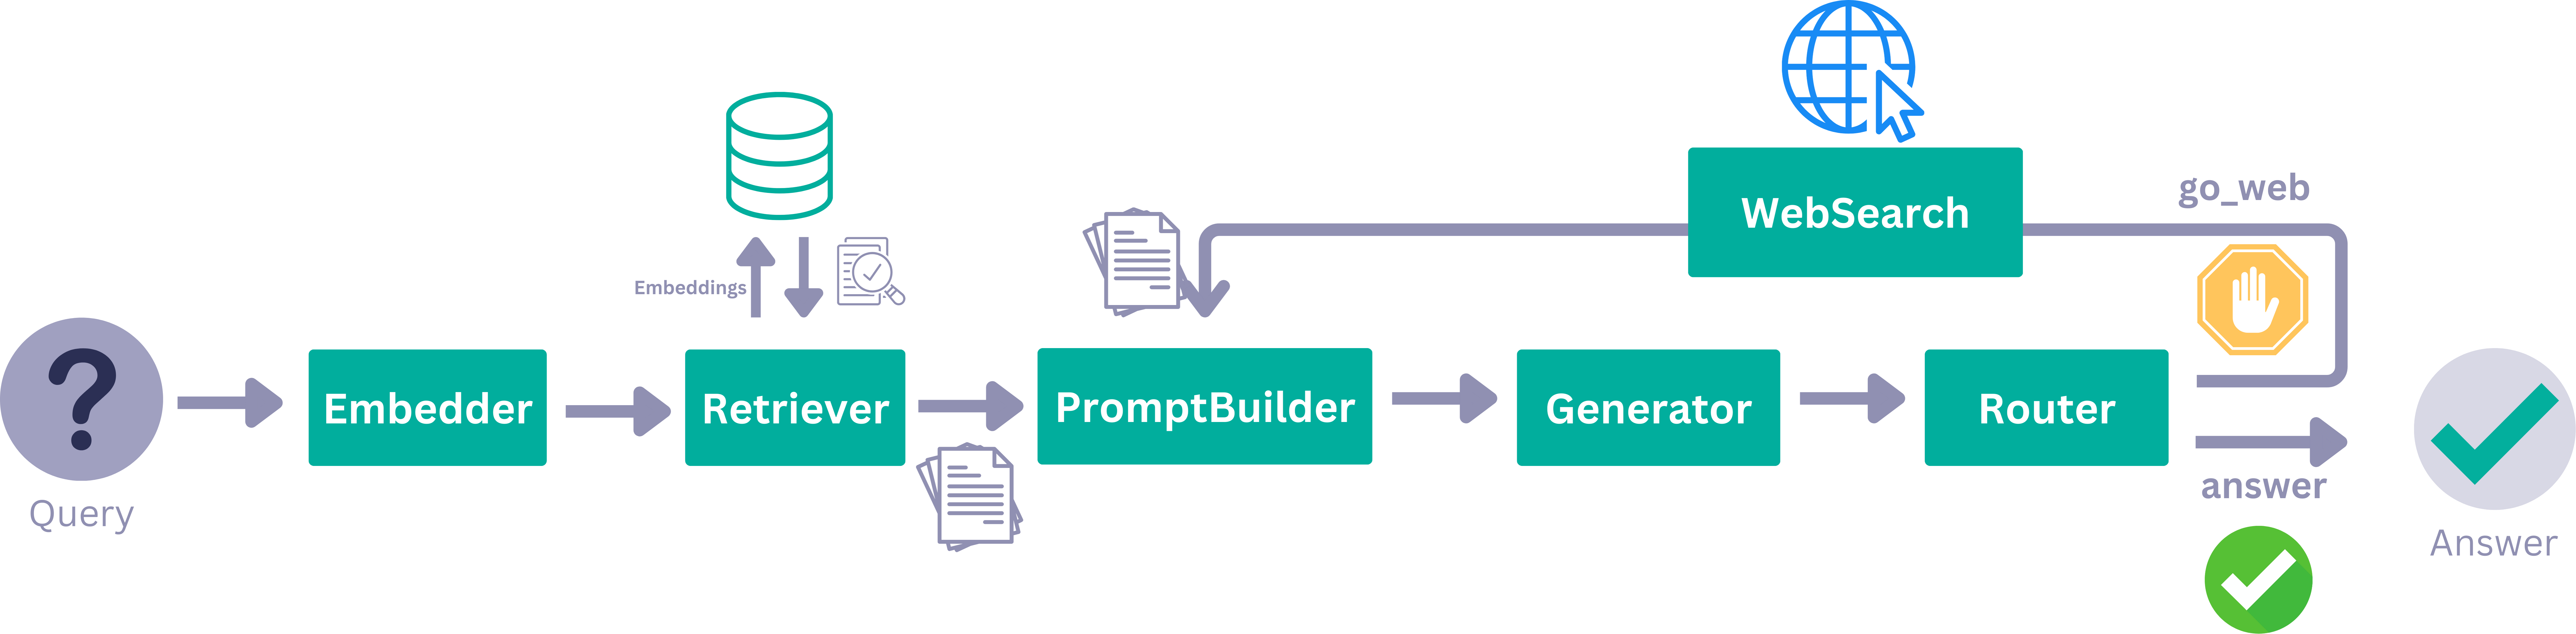

## Install Dependencies

In [ ]:
!pip install -U ollama-haystack git+https://github.com/deepset-ai/haystack.git@main

## Enable Tracing

In [ ]:
import logging
from haystack import tracing
from haystack.tracing.logging_tracer import LoggingTracer

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.DEBUG)

tracing.tracer.is_content_tracing_enabled = True # to enable tracing/logging content (inputs/outputs)
tracing.enable_tracing(LoggingTracer(tags_color_strings={"haystack.component.input": "\x1b[1;31m", "haystack.component.name": "\x1b[1;34m"}))

### Disable Tracing

In [ ]:
tracing.tracer.is_content_tracing_enabled = False
tracing.disable_tracing()

## Index Documents for the Agent

In [2]:
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.writers import DocumentWriter
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter

document_store = InMemoryDocumentStore()

# Indexing pipeline
indexing_pipeline = Pipeline()
indexing_pipeline.add_component(instance=LinkContentFetcher(), name="fetcher")
indexing_pipeline.add_component(instance=HTMLToDocument(), name="converter")
indexing_pipeline.add_component(instance=DocumentCleaner(), name="cleaner")
indexing_pipeline.add_component(instance=DocumentSplitter(split_by="sentence", split_length=5, split_overlap=1), name="splitter")
indexing_pipeline.add_component(instance=DocumentWriter(document_store = document_store), name="writer")

indexing_pipeline.connect("fetcher.streams", "converter.sources")
indexing_pipeline.connect("converter.documents", "cleaner")
indexing_pipeline.connect("cleaner", "splitter")
indexing_pipeline.connect("splitter", "writer.documents")

# index some documentation pages to use for RAG
indexing_pipeline.run({
    "fetcher": {
        "urls": [
            "https://docs.haystack.deepset.ai/docs/generators-vs-chat-generators",
            "https://docs.haystack.deepset.ai/docs/ollamagenerator",
            "https://haystack.deepset.ai/overview/quick-start",
            "https://haystack.deepset.ai/overview/intro"
            ]}})

/Users/bilgeyucel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


{'writer': {'documents_written': 70}}

## API Keys

In [3]:
import os

os.environ["SERPERDEV_API_KEY"] = "***"

## Build the Agent

### Routes

In [4]:
from haystack.components.routers import ConditionalRouter

main_routes = [
    {
        "condition": "{{'N0_ANSWER' in replies[0].replace('\n', '')}}",
        "output" :"{{query}}",
        "output_name": "go_web",
        "output_type": str,
    },
    {
        "condition": "{{'NO_ANSWER' not in replies[0].replace('\n', '')}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

### Agent Prompt

In [5]:
agent_prompt_template = """<start_of_turn>user
{% if web_documents %}
    You were asked to answer the following query given the documents retrieved from Haystack's documentation but the context was not enough.
    Here is the user question: {{ query }}
    Context:
    {% for document in documents %}
        {{document.content}}
    {% endfor %}
    {% for document in web_documents %}
    URL: {{document.meta.link}}
    TEXT: {{document.content}}
    ---
    {% endfor %}
    Answer the question based on the given context.
    If you have enough context to answer this question, return your answer with the used links.
    If you don't have enough context to answer, say 'N0_ANSWER'.
{% else %}
Answer the following query based on the documents retrieved from Haystack's documentation.

Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}

Query: {{query}}

If you have enough context to answer this question, just return your answer
If you don't have enough context to answer, say 'N0_ANSWER'.
{% endif %}

<end_of_turn>
<start_of_turn>model
"""

## Web-Enhanced Self-Reflecting Agent

In [6]:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryBM25Retriever
from haystack.components.websearch import SerperDevWebSearch
from haystack.components.builders import PromptBuilder
from haystack_integrations.components.generators.ollama import OllamaGenerator

self_reflecting_agent = Pipeline(max_runs_per_component=5)
self_reflecting_agent.add_component("retriever", InMemoryBM25Retriever(document_store=document_store, top_k=3))
self_reflecting_agent.add_component("prompt_builder_for_agent", PromptBuilder(template=agent_prompt_template))
self_reflecting_agent.add_component("llm_for_agent", OllamaGenerator(model="gemma2:9b-instruct-q4_1", url = "http://localhost:11434"))
self_reflecting_agent.add_component("web_search", SerperDevWebSearch())
self_reflecting_agent.add_component("router", ConditionalRouter(main_routes))

self_reflecting_agent.connect("retriever.documents", "prompt_builder_for_agent.documents")
self_reflecting_agent.connect("prompt_builder_for_agent", "llm_for_agent")
self_reflecting_agent.connect("llm_for_agent.replies", "router.replies")
self_reflecting_agent.connect("router.go_web", "web_search.query")
self_reflecting_agent.connect("web_search.documents", "prompt_builder_for_agent.web_documents")


🚅 Components
  - retriever: InMemoryBM25Retriever
  - prompt_builder_for_agent: PromptBuilder
  - llm_for_agent: OllamaGenerator
  - web_search: SerperDevWebSearch
  - router: ConditionalRouter
🛤️ Connections
  - retriever.documents -> prompt_builder_for_agent.documents (List[Document])
  - prompt_builder_for_agent.prompt -> llm_for_agent.prompt (str)
  - llm_for_agent.replies -> router.replies (List[str])
  - web_search.documents -> prompt_builder_for_agent.web_documents (List[Document])
  - router.go_web -> web_search.query (str)

In [7]:
query = "What is Haystack?"
result = self_reflecting_agent.run({"retriever":{"query":query}, "prompt_builder_for_agent":{"query":query}, "router":{"query":query}}, include_outputs_from={"retriever", "router", "llm_for_agent", "web_search", "prompt_builder_for_agent"})

/Users/bilgeyucel/Library/Python/3.9/lib/python/site-packages/haystack/core/pipeline/pipeline.py:521: RuntimeWarning: Pipeline is stuck running in a loop. Partial outputs will be returned. Check the Pipeline graph for possible issues.
  warn(RuntimeWarning(msg))


In [8]:
print(result["router"]["answer"])

Haystack is an open source framework for building production-ready LLM applications, retrieval-augmented generative pipelines and state-of-the-art search systems that work intelligently over large document collections. It lets you quickly try out the latest AI models while being flexible and easy to use. Our inspiring community of users and builders has helped shape Haystack into the modular, intuitive, complete framework it is today. 



In [9]:
query = "What's Gemma2?"
result= self_reflecting_agent.run({"retriever":{"query":query}, "prompt_builder_for_agent":{"query":query}, "router":{"query":query}}, include_outputs_from={"retriever", "router", "llm_for_agent", "web_search", "prompt_builder_for_agent"})

In [10]:
print(result["router"]["answer"])

Gemma 2 is Google's latest iteration of open LLMs. It comes in two sizes, 9 billion and 27 billion parameters with base (pre-trained) and instruction-tuned versions.  

**Used Links:**
https://huggingface.co/blog/gemma2




